In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np


### policy paths

In [101]:
bart_policy_path = "./policy/bart-policy.csv"
base_policy_path = "./policy/base-policy.csv"
small_policy_path = "./policy/small-policy.csv"

policy_paths = [bart_policy_path, base_policy_path, small_policy_path]

### no policy paths

In [102]:
bart_no_policy_path = "./no-policy/bart_no_policy.csv"
base_no_policy_path = "./no-policy/base_no_policy.csv"
small_no_policy_path = "./no-policy/small_no_policy.csv"

no_policy_paths = [small_no_policy_path, base_no_policy_path, bart_no_policy_path]

In [103]:
# read the policy file as dataframe
df_test = pd.read_csv(bart_no_policy_path)

In [104]:
df_test.columns

Index(['energon_total_in_power_mW', 'energon_cpu_in_power_mW',
       'energon_gpu_in_power_mW', 'energon_cpu_total_usage_percentage',
       'energon_gpu_total_usage_percentage', 'energon_ram_used_percentage',
       'timestamp'],
      dtype='object')

In [105]:
def find_first_gpu_usage_higher_than_threshold(df, threshold):
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] > threshold:
            return i
    return -1

def find_last_gpu_usage_higher_than_threshold(df, threshold):
    result = -1
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] > threshold:
            result = i
        elif result != -1:
            return result
    
    return result

# check if df contains -1 in the column c
def check_for_minus_one(df, c):
    for i, row in df.iterrows():
        if row[c] == -1:
            return True
    return False

# count the number of missing values in the dataframe
def count_missing_values(df):
    count = 0
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] < 0 or row["energon_total_in_power_mW"] < 0:
            count += 1
    return count

In [106]:
count_missing_values(df_test)


48

./policy/bart-policy.csv differece 2228.8450000286102
./policy/base-policy.csv differece 1584.233999967575
./policy/small-policy.csv differece 1154.37700009346


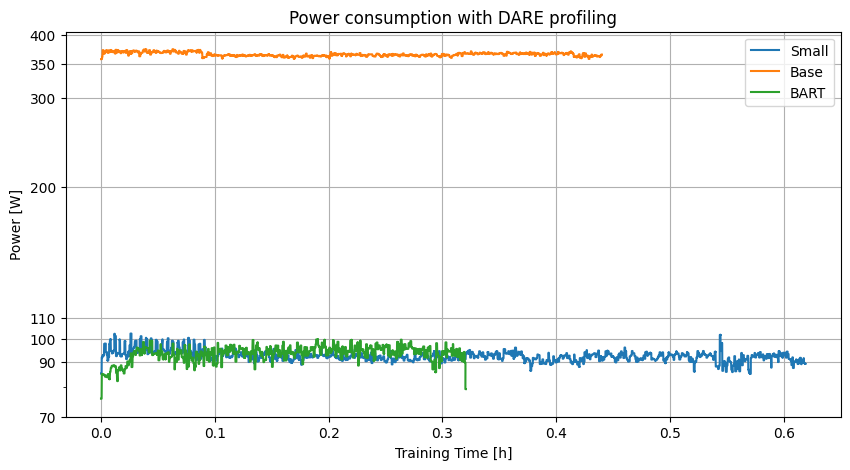

In [150]:
plt.figure(figsize=(10, 5))
for df_path in policy_paths:
    df = pd.read_csv(df_path)

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    min_time_stamp = df["timestamp"].min()
    max_time_stap = df["timestamp"].max()

    print(df_path, "differece", max_time_stap - min_time_stamp)

    avg_time = df["timestamp"].diff().mean()
    std_time = df["timestamp"].diff().std()

    x_axis = []
    for i in range(len(energy_total)):
        x_axis.append(i * avg_time + random.uniform(-std_time, std_time))

    # x_axis is in seconds convert it to hours
    x_axis = [x / 3600 for x in x_axis]

    # show grid
    plt.grid(True)

    plt.plot(x_axis, energy_total)
    plt.legend(["Small", "Base", "BART"])
    plt.ylabel("Power [W]")
    plt.xlabel("Training Time [h]")
    plt.title("Power consumption with DARE profiling")

    plt.gca().set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
    plt.gca().set_yticks([70, 90, 100, 110, 200, 300, 350, 400])
    plt.gca().set_yticklabels([70, 90, 100, 110, 200, 300, 350, 400])


./no-policy/small_no_policy.csv differece 61404.05500006676
./no-policy/base_no_policy.csv differece 141987.64184201873
./no-policy/bart_no_policy.csv differece 47806.575000047684


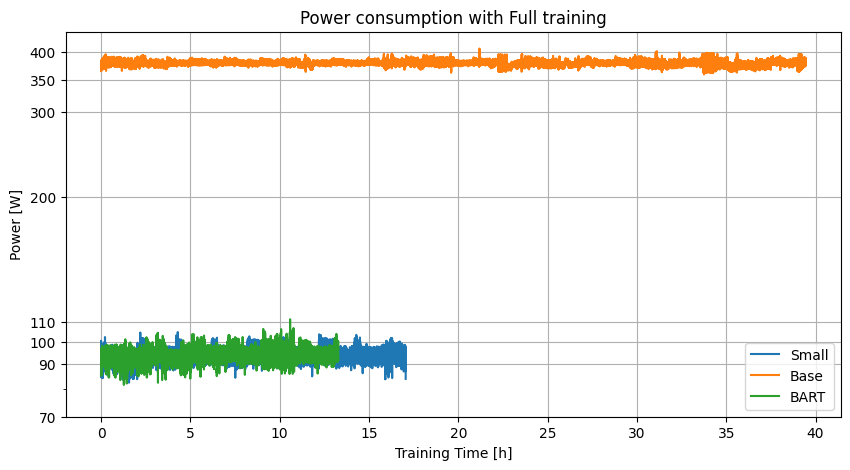

In [149]:
plt.figure(figsize=(10, 5))
for df_path in no_policy_paths:
    df = pd.read_csv(df_path)

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    max_time_stap = df["timestamp"].max()
    min_time_stamp = df["timestamp"].min()

    print(df_path, "differece", max_time_stap - min_time_stamp)

    avg_time = df["timestamp"].diff().mean()
    std_time = df["timestamp"].diff().std()

    x_axis = []
    for i in range(len(energy_total)):
        x_axis.append(i * avg_time + random.uniform(-std_time, std_time))

    # x_axis is in seconds convert it to hours
    x_axis = [x / 3600 for x in x_axis]

    # set figure height and width

    # show grid
    plt.grid(True)

    plt.plot(x_axis, energy_total)
    plt.legend(["Small", "Base", "BART"])
    plt.ylabel("Power [W]")
    plt.xlabel("Training Time [h]")
    plt.title("Power consumption with Full training")

    plt.gca().set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
    plt.gca().set_yticks([70, 90, 100, 110, 200, 300, 350, 400])
    plt.gca().set_yticklabels([70, 90, 100, 110, 200, 300, 350, 400])


In [109]:
import numpy as np
from scipy.integrate import simps
from numpy import trapz

In [110]:
labels = []
simps_energies = []
for df_path in no_policy_paths:
    df = pd.read_csv(df_path)

    labels.append("no_p_" + df_path.split("/")[2].split("_")[0])

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    simps_energy = simps(energy_total, dx=1)

    simps_energies.append(simps_energy)

for df_path in policy_paths:
    df = pd.read_csv(df_path)

    labels.append(df_path.split("/")[2].split("-")[0])

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    simps_energy = simps(energy_total, dx=1)

    simps_energies.append(simps_energy)




In [111]:
pow_value = 3
def custom_transform(x):
    r = np.power(x, 1/pow_value)
    # check if np r array containeys nan
    if np.isnan(r).any():
        # repplace nan with 0
        r = np.nan_to_num(r)
    return r

def custom_inverse_transform(x):
    return np.power(x, pow_value)

In [112]:
labels

['no_p_small', 'no_p_base', 'no_p_bart', 'bart', 'base', 'small']

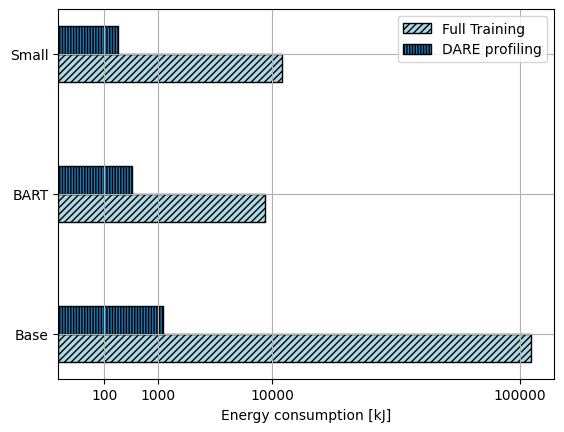

In [135]:
# trapz_energies is in J, convert kJ
_simps_energies = [x / 1000 for x in simps_energies]

to_plot_no_p = [_simps_energies[1], _simps_energies[2], _simps_energies[0]]    
to_plot_p = [_simps_energies[4], _simps_energies[3], _simps_energies[5]]

# Set the width of the bars
bar_width = 0.2

colors = ["lightblue", "#fad6a5", "#FF7276", "pink", "purple", "#E7D7AF", "#90EE90", "gray"]

labels = ['Base', 'BART', 'Small']

# Position of bars on the x-axis
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.yticks([r + bar_width * 1.5 for r in range(len(labels))], labels)

plt.barh(r2, to_plot_no_p, height=bar_width, color=colors[0], edgecolor='black', label='Full Training', hatch="/////")
plt.barh(r3, to_plot_p, height=bar_width, edgecolor='black', label='DARE profiling', hatch="||||||")


plt.xlabel('Energy consumption [kJ]')

plt.gca().set_xscale("function", functions=[custom_transform, custom_inverse_transform])
x_ticks = [ 100, 1000, 10000, 100000]
plt.gca().set_xticks(x_ticks)

plt.grid(True)
plt.legend()

# plt.gca().set_xticklabels(x_ticks)
# plt.gca().set_xticks(x_ticks)
# plt.gca().set_xticks([0, 400, 1000, 2000, 3000, 5000, 6500])
# plt.gca().set_xticklabels([0, 400, 1000, 2000, 3000, 5000, 6500])


